## Medical image data - BoneMRI


In [1]:
# Library imports
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pydicom
import os
import cv2

from image_utils import *

data_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS23")
segmentation_path = os.path.join("boneMRI", "20240119_BoneMRI_EBS23_Segmentations.nii")

## Loading the data

The shape of the image is (100, 672, 672)


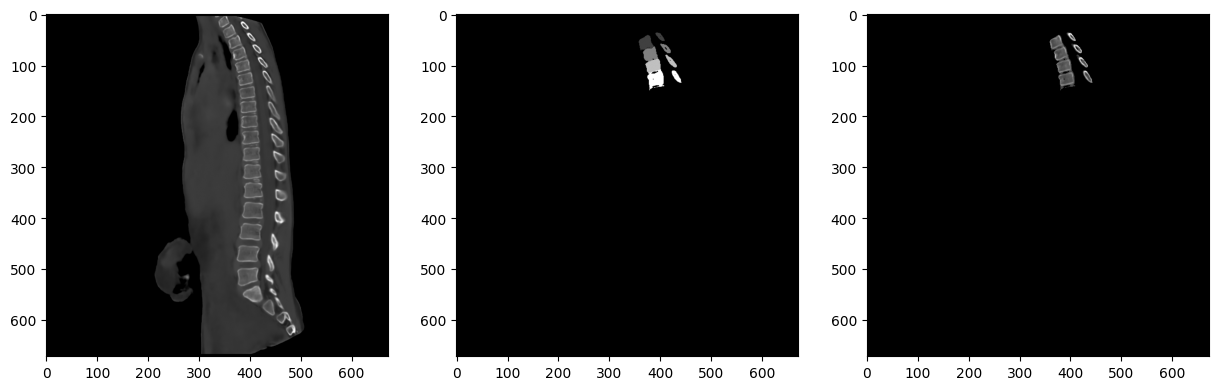

In [2]:
# Load segmentation data
segment = nib.load(segmentation_path)
segment_data = np.transpose(segment.get_fdata())
segment_header = segment.header
segment_all = segment_data > 0

# Load dicom data and apply windowing
dicom_image = load_3d_dicom(data_path)
dicom_image = apply_window(dicom_image, window_level=450, window_width=1500)
segment_dicom_image = dicom_image*segment_all
print(f"The shape of the image is {dicom_image.shape}")

# Plot data 
slice_index = 50  # Middle slice along the z-axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(dicom_image[slice_index, :, :], cmap='gray')
ax[1].imshow(segment_data[slice_index, :, :], cmap='gray')
ax[2].imshow(segment_dicom_image[slice_index, :, :], cmap='gray');

## Image compression to 2D

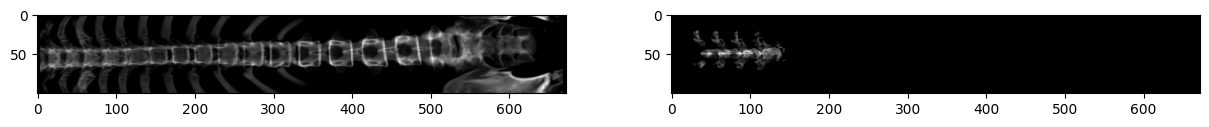

In [4]:
# Compress image
compressed_dicom_image = compress_bonemri(dicom_image, axis=2)
compressed_segment_dicom_image = compress_bonemri(segment_dicom_image, axis=2)

# Plot data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(compressed_dicom_image, cmap='gray')
ax[1].imshow(compressed_segment_dicom_image, cmap='gray');

## Image rotation

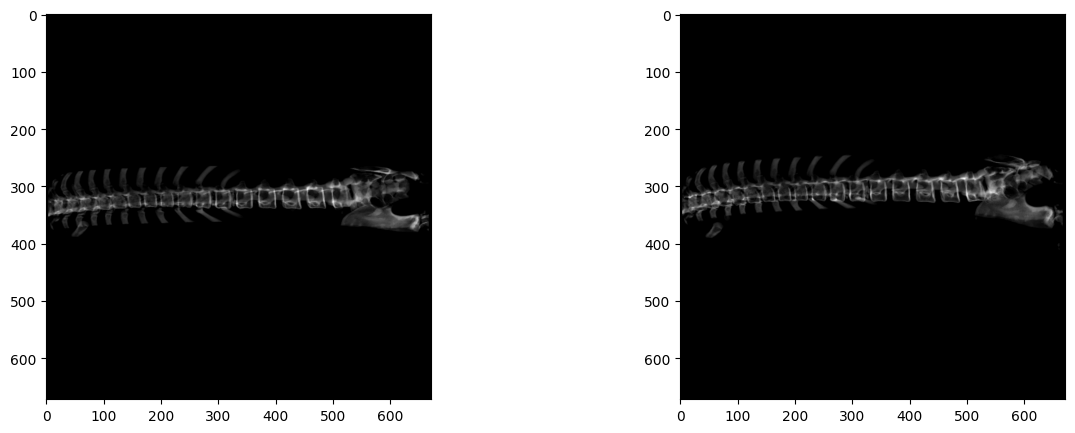

In [13]:
# Rotate full images
rotated_spine_10 = rotate_image(dicom_image, axis=1, angle=10)
rotated_spine_20 = rotate_image(dicom_image, axis=1, angle=20)

# Compress images
compressed_rotated_spine_10 = compress_bonemri(rotated_spine_10, axis=2)
compressed_rotated_spine_20 = compress_bonemri(rotated_spine_20, axis=2)

# Plot data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(compressed_rotated_spine_10, cmap='gray')
ax[1].imshow(compressed_rotated_spine_20, cmap='gray');